In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Visualize Data

In [2]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


train_path = '/content/drive/MyDrive/squares/train/'
val_path = '/content/drive/MyDrive/squares/val/'

In [3]:
number_classes = {
    'Class a': len(os.listdir(os.path.join(train_path, 'a'))),
    'Class b': len(os.listdir(os.path.join(train_path, 'b'))),
    'Class c': len(os.listdir(os.path.join(train_path, 'c')))
}

Text(0, 0.5, '# Images')

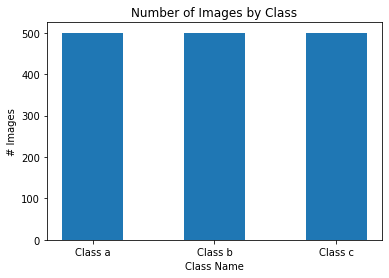

In [ ]:
plt.bar(number_classes.keys(), number_classes.values(), width = .5)
plt.title("Number of Images by Class")
plt.xlabel('Class Name')
plt.ylabel('# Images')

In [ ]:
from PIL import Image
directories = {
    'Class a': os.path.join(train_path, 'a'),
    'Class b': os.path.join(train_path, 'b'),
    'Class c': os.path.join(train_path, 'c')
    }

def get_dims(file):
    im = Image.open(file)
    arr = np.array(im)
    h,w,d = arr.shape
    return h,w

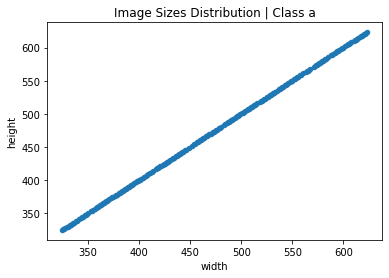

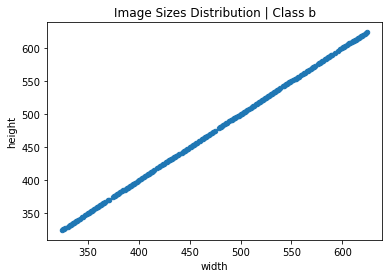

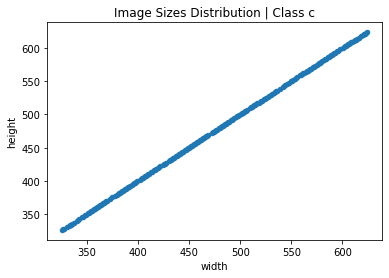

In [ ]:
for key, folder in directories.items():
    height, width = [], []
    for file in os.listdir(folder):
        if file.endswith('.jpg') or file.endswith('.png') or file.endswith('.bmp'):
            h, w = get_dims(os.path.join(folder, file))
            height.append(h)
            width.append(w)

    dim_df = pd.DataFrame(list(zip(height, width)), columns=['height', 'width'])
    sizes = dim_df.groupby(['height', 'width']).size().reset_index().rename(columns={0:'count'})
    sizes.plot.scatter(x='width', y='height');
    plt.title('Image Sizes Distribution | {}'.format(key))

# CNN

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [5]:
import pathlib

data_dir = pathlib.Path('/content/drive/MyDrive/squares/train/')
val_dir = pathlib.Path('/content/drive/MyDrive/squares/val/')

In [6]:
image_count = len(list(data_dir.glob('*/*.*')))
print(image_count)

1500


In [7]:
batch_size = 32
img_height = 512
img_width = 512

In [8]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1500 files belonging to 3 classes.


In [9]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  val_dir,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1500 files belonging to 3 classes.


In [10]:
class_names = train_ds.class_names
print(class_names)

['a', 'b', 'c']


In [11]:
class_tempnames = val_ds.class_names
print(class_tempnames)

['a', 'b', 'c']


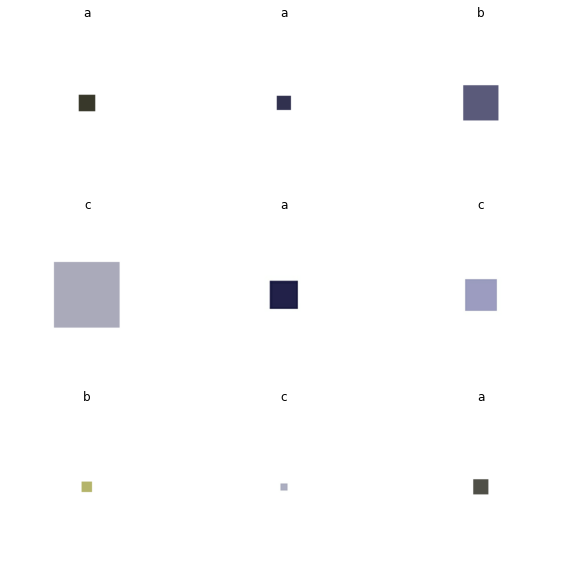

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [ ]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 512, 512, 3)
(32,)


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [12]:
num_classes = 3

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [13]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 512, 512, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 512, 512, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 256, 256, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 64)      18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 64, 64, 64)        0

In [15]:
from keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint(filepath='/content/drive/MyDrive/squares/orig.pth', 
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min')

In [17]:
epochs=15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[checkpoint]
)

Epoch 1/15
47/47 [==============================] - 1056s 11s/step - loss: 2.2035 - accuracy: 0.4840 - val_loss: 0.5789 - val_accuracy: 0.8527

Epoch 00001: val_loss improved from inf to 0.57891, saving model to /content/drive/MyDrive/squares/orig.pth
INFO:tensorflow:Assets written to: /content/drive/MyDrive/squares/orig.pth/assets
Epoch 2/15
47/47 [==============================] - 17s 358ms/step - loss: 0.3816 - accuracy: 0.8673 - val_loss: 0.1805 - val_accuracy: 0.9553

Epoch 00002: val_loss improved from 0.57891 to 0.18049, saving model to /content/drive/MyDrive/squares/orig.pth
INFO:tensorflow:Assets written to: /content/drive/MyDrive/squares/orig.pth/assets
Epoch 3/15
47/47 [==============================] - 16s 352ms/step - loss: 0.1263 - accuracy: 0.9513 - val_loss: 0.1348 - val_accuracy: 0.9533

Epoch 00003: val_loss improved from 0.18049 to 0.13475, saving model to /content/drive/MyDrive/squares/orig.pth
INFO:tensorflow:Assets written to: /content/drive/MyDrive/squares/orig.p

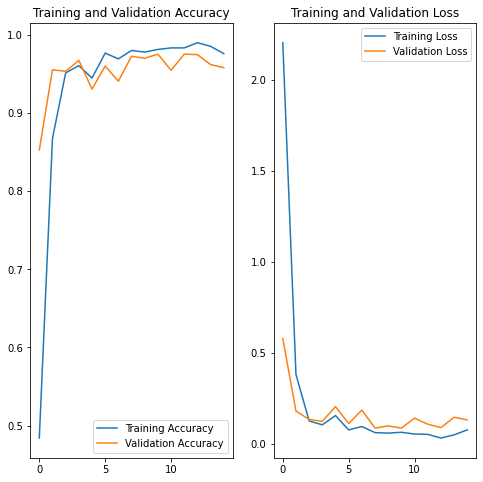

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [19]:
y_pred = model.predict(val_ds, batch_size=32)
y_pred = np.argmax(y_pred, axis=1)
# print(len(y_pred))


temp = list(map(lambda x: x[1], val_ds))
y_true = []
for batch in temp:
    y_true.extend(batch.numpy())

In [20]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix

classification_metrics = metrics.classification_report(np.asarray(y_true), y_pred, target_names=class_names)
print(classification_metrics)

              precision    recall  f1-score   support

           a       0.97      0.99      0.98       500
           b       0.99      0.88      0.93       500
           c       0.92      1.00      0.96       500

    accuracy                           0.96      1500
   macro avg       0.96      0.96      0.96      1500
weighted avg       0.96      0.96      0.96      1500



# Transfer Learning
[Referenced](https://www.tensorflow.org/tutorials/images/transfer_learning)

In [ ]:
batch_size = 32
img_height = 160
img_width = 160

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1500 files belonging to 3 classes.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  val_dir,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1500 files belonging to 3 classes.


In [ ]:
val_batches = tf.data.experimental.cardinality(val_ds)
test_dataset = val_ds.take(val_batches // 5)
val_ds = val_ds.skip(val_batches // 5)

In [ ]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(val_ds))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 38
Number of test batches: 9


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [ ]:
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)

In [ ]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = (img_width, img_height) + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9420800/9406464 [==============================] - 0s 0us/step


In [ ]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [ ]:
base_model.trainable = False

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [ ]:
prediction_layer = tf.keras.layers.Dense(3)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 3)


In [ ]:
inputs = tf.keras.Input(shape=(160, 160, 3))
# x = data_augmentation(inputs)
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
tf.math.truediv_1 (TFOpLambd (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract_1 (TFOpLamb (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 3843

In [ ]:
initial_epochs = 50

loss0, accuracy0 = model.evaluate(val_ds)

38/38 [==============================] - 12s 174ms/step - loss: 1.1767 - accuracy: 0.3556


In [ ]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 1.18
initial accuracy: 0.36


In [ ]:
history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds)

Epoch 1/50
47/47 [==============================] - 23s 383ms/step - loss: 1.1570 - accuracy: 0.3793 - val_loss: 1.0193 - val_accuracy: 0.5124
Epoch 2/50
47/47 [==============================] - 18s 366ms/step - loss: 1.0478 - accuracy: 0.4633 - val_loss: 0.9403 - val_accuracy: 0.6023
Epoch 3/50
47/47 [==============================] - 19s 368ms/step - loss: 0.9618 - accuracy: 0.5220 - val_loss: 0.8704 - val_accuracy: 0.6568
Epoch 4/50
47/47 [==============================] - 19s 370ms/step - loss: 0.9088 - accuracy: 0.5800 - val_loss: 0.8287 - val_accuracy: 0.6733
Epoch 5/50
47/47 [==============================] - 19s 369ms/step - loss: 0.8681 - accuracy: 0.5933 - val_loss: 0.7882 - val_accuracy: 0.6881
Epoch 6/50
47/47 [==============================] - 18s 365ms/step - loss: 0.8319 - accuracy: 0.6207 - val_loss: 0.7532 - val_accuracy: 0.7046
Epoch 7/50
47/47 [==============================] - 19s 366ms/step - loss: 0.8021 - accuracy: 0.6200 - val_loss: 0.7320 - val_accuracy: 0.7021

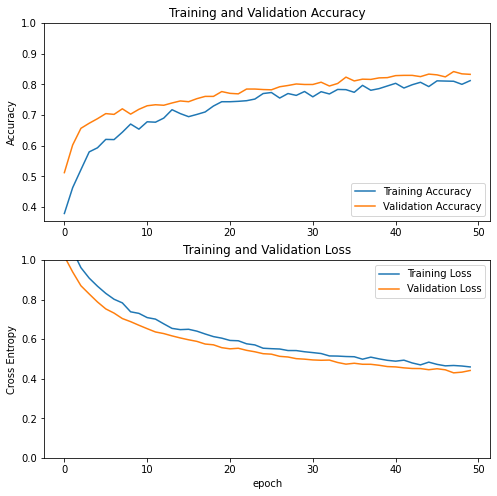

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()